## Traning model for classification of extracted phrases from selected CVs 

### The code below contains a training example. This is not the model used for the final solution. 

Very important point. Use ONLY transformers==2.5.1 in the environment:

pip install "transformers==2.5.1"

In [1]:
# Import libraries and packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import numpy as np
np.random.seed(0)
import pandas as pd
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
import re
from tqdm import tqdm, trange
import os
import gc

import random
from nltk import ngrams

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

### Data preparation

Customized list of stop words. The list is not used in model generation. 
I use the list to visualize the frequency of occurrence of words in phrases. 

In [ ]:
# customized list of stop words:
customized_stop_words_ = ['st', 'in', 'an', 'be', 'es', 'li', 'ein', 'und', 'der', 'ten', 'zu', 'bei',
 'la', 'den', 'auf', 'ab', 'arbeit', 'mit', 'ist', 'die', 'wir', 'eine', 'im', 'du', 'aus', 'uns', 
 'am', 'sie', 'für', 'fi', 'von', 'ihr', 'unser', 'ihre', 'art', 'sich', 'über', 'oder', 'unsere', 'aufgaben',
 'ins', 'stelle', 'ul', 'teil', 'zur', 'des', 'als', 'voll', 'nach', 'wie', 'das', 'sind', 'sw',
 'bereich', 'lage', 'unternehmen', 'möglich', 'fach', 'einen', 'mitarbeit', 'land', 'durch', 'zum', 'sowie',
 'dies', 'mitarbeiter', 'hin', 'dem', 'sz', 'op', 'sicher', 'bieten', 'auch', 'ihnen', 'arbeiten', 'einem',
 'einer', 'bar', 'haben', 'hand', 'neu', 'tätig', 'antwort', 'betrieb', 'gern', 'up', 'wert', 'bereits',
 'werde', 'fort', 'tätigkeit', 'werden', 'unseren', 'gn', 'unterlagen', 'dir', 'führung', 'entwicklung', 
 'betreuung', 'erp', 'ihrer', 'nicht', 'werk', 'unserer', 'neue', 'branche', 'sd', 'interesse', 'persönliche',
 'verantwortung', 'sehr', 'ihren', 'bringen', 'weiterbildung', 'post', 'eines', 'div', 'qualität',
 'geld', 'arbeitsplatz', 'ref', 'wenn', 'hoch', 'nur', 'unternehmens', 'raum', 'menschen', 'chance',
 'unserem', 'weiteren', 'übernahme', 'umfeld', 'zukunft', 'unseres', 'dieser', 'gebiet', 'setzen', 'bzw', 'noch',
 'rahmen', 'nächstmöglichen', 'abwechslungsreiche', 'ihrem', 'bereichen', 'dein', 'kennen', 'verfügung', 
 'dabei', 'folgende', 'einarbeitung', 'kompetenz', 'deine', 'start', 'arbeitsvertrag',
 'stellenangebots', 'erhalten', 'dich', 'prozesse', 'lösungen', 'abteilung', 'festanstellung', 'blick', 'our'
 'wochen', 'schwerpunkt', 'entsprechend', 'gesundheits', 'erfolgt', 'leiter', 'gemeinsam', 'freude', 'vertrieb',
 'weiterentwicklung', 'verständnis', 'westfalen', 'standorten', 'denen', 'basis', 'gestaltung', 'neben',
 'entwickeln', 'umsetzung', 'aufgabengebiet', 'spaß', 'vielfältige', 'einrichtung', 'bist', 'gestalten',
 'schulung', 'herstellung', 'gehören', 'geschick', 'anspruchsvolle', 'versorgung', 'option', 'fertigung',
 'wieder', 'herausforderungen', 'vertriebs', 'geräte', 'während', 'themen', 'schnelle',
 'begleitung', 'vielen', 'main', 'voraussetzungen', 'insbesondere', 'vorzugsweise', 'verschiedenen', 'zentrale',
 'hierarchien', 'abwicklung', 'größten', 'eingang', 'neues', 'überzeugen', 'anwendungen', 'bedienung',
 'begleiten', 'erfolgreichen', 'daher', 'sowohl', 'brand', 'abrechnung', 'key', 'plus',
 'aufgabenbereich', 'gesamten', 'partnern', 'intensive', 'stets', 'angenehmes', 'fachbereich', 'freitag',
 'deinen', 'tief', 'dynamischen', 'beispiel', 'global', 'helfen', 'wachsenden', 'methoden', 'mitwirkung',
 'sales', 'abwechslungsreichen', 'title', 'genehmigung', 'luft', 'geräten', 'unterschiedlichen', 'offenen', 
 'allem', 'moderner', 'lifestyle', 'umwelt', 'anspruchsvollen', 'herzen', 'entladen',
 'erwünscht' 'nachhaltige', 'behörde', 'empfang', 'einführung', 'komplexen', 'corporate',
 'fragestellungen', 'content', 'aufnehmen', 'arbeitsvorbereitung', 'ã', 'mitglieder', 'stepstone', 
 'verfügst', 'komplexer', 'straßen', 'betten', 'product', 'besitzt', 'sechs', 'planb', 'favoriten', 'fã¼r',
 'requirements', 'robert', 'mã', 'innere', 'using'
 # added by hand:
 'weitere', 'gerne', 'dann', 'jetzt', 'fragen', 'seine', 'letze', 'denn', 'suchen', 'genau', 'freuen', 'jeder'] 
print (len(customized_stop_words_))

In [3]:
# load the csv data:
# 
# replace 'csv_dir_' by proper directory !! For example: csv_dir_ = /tmp/df_final/
csv_dir_ = '/home/bogdan/Desktop/projects/MODIS/Connex/data/CVs_labels/'
filename_ = 'df_final.csv'
df = pd.read_csv(os.path.join(csv_dir_,filename_))
df.shape

(3563, 2)

In [5]:
df.tag.unique()

array([0., 4., 3., 5., 2., 1.])

### Data cleaning:

In [18]:
# clean up:
df.isnull().sum(axis=0)

entry    0
tag      0
dtype: int64

In [19]:
# remove rows with empty sentence
df[df.entry.isnull()]

,entry,tag


In [20]:
df.dropna(subset=['entry'], inplace=True)
df.shape, df.isnull().sum(axis=0)

((3563, 2),
 entry    0
 tag      0
 dtype: int64)

In [21]:
df.drop_duplicates(subset=['entry'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 3562
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   entry   3382 non-null   object 
 1   tag     3382 non-null   float64
dtypes: float64(1), object(1)
memory usage: 79.3+ KB


In [22]:
# lower letters
df['entry'] = df['entry'].str.lower()

In [23]:
df.describe()

,tag
count,3382.000000
mean,2.406564
std,1.463746
min,0.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,5.000000


### Overview of the data and visualization:

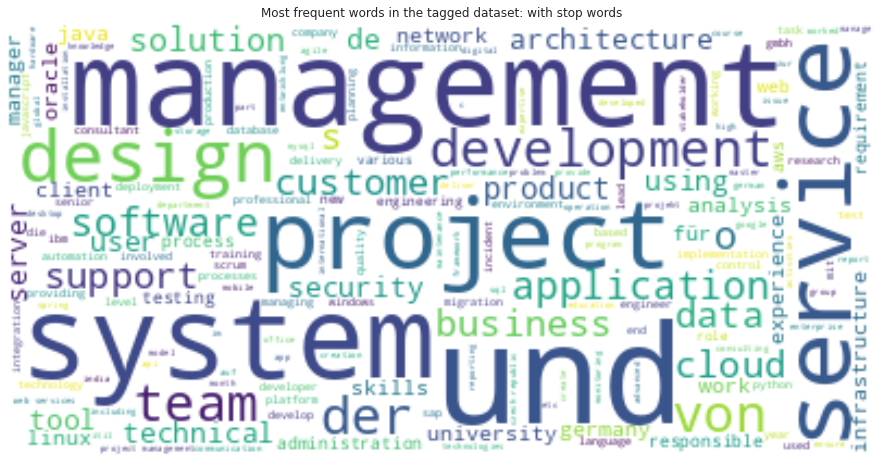

In [25]:
from wordcloud import WordCloud
text = " ".join([x for x in df.entry])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most frequent words in the tagged dataset: with stop words') #('before stop words removal:')
plt.axis('off')
plt.show()

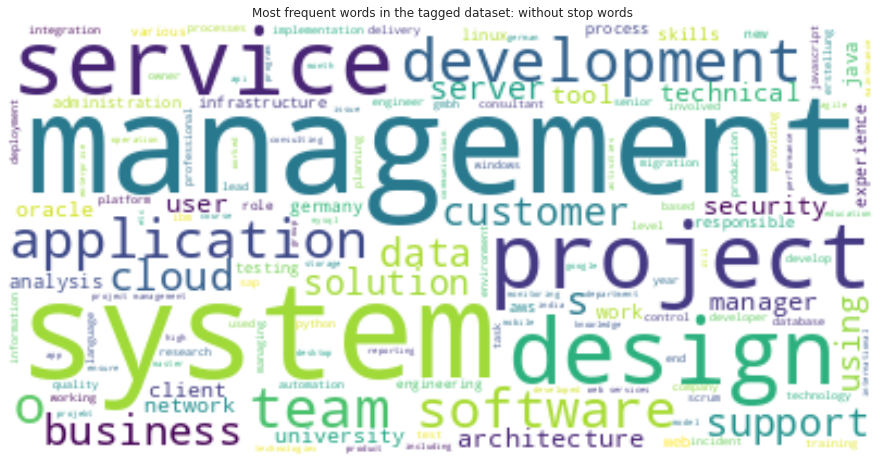

CPU times: user 526 ms, sys: 3.88 ms, total: 530 ms
Wall time: 529 ms


In [26]:
%%time
# removed stop words:
text = " ".join([x for x in df.entry])
text_filtered_ = " ".join([word for word in text.split() if word.lower() not in customized_stop_words_])
wordcloud = WordCloud(background_color='white').generate(text_filtered_)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most frequent words in the tagged dataset: without stop words')
plt.axis('off')
plt.show()

#### Distribution of available labels:

/home/bogdan/anaconda3/envs/py37_1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


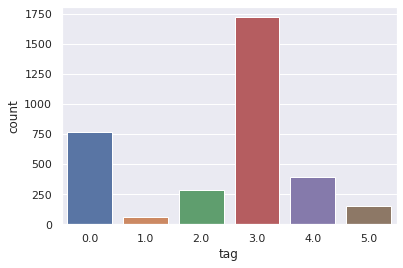

In [27]:
sns.countplot(df.tag)
plt.show()

### Preparation of train/test samples:

In [28]:
# stratified split data:
from sklearn.model_selection import train_test_split

# renaming of columns - requested by the transformers:
df_ = pd.DataFrame({
    'text': df['entry'],
    'labels': df['tag']
})

train_df, eval_df = train_test_split(df_, test_size=0.05, stratify=df['tag'])
print (train_df.shape, eval_df.shape)

(3212, 2) (170, 2)


In [29]:
df['tag'].value_counts()

3.0    1721
0.0     768
4.0     396
2.0     287
5.0     152
1.0      58
Name: tag, dtype: int64

In [30]:
train_df.head()

,text,labels
723,"integrate new tools like webpack, babel or jest in the pipeline",3.0
2663,"expertise in managing diverse linux systems and handling installation, troubleshooting required configuration for linux.",3.0
108,product manager for pon pol solutions abf systems adc 3 2003 – 2 2007,3.0
550,services.,0.0
2544,"productmanager for software and multimedia applikationen at tronic verlag, eschwege germany",3.0


/home/bogdan/anaconda3/envs/py37_1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


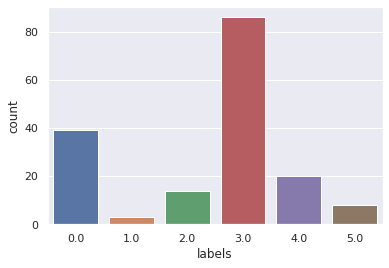

In [31]:
sns.countplot(eval_df.labels)
plt.show()

In [32]:
eval_df['labels'].value_counts()

3.0    86
0.0    39
4.0    20
2.0    14
5.0     8
1.0     3
Name: labels, dtype: int64

## Transformer's part:

In [33]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# import local functions:
from model_classification import * 

In [34]:
print (transformers.__version__)

2.5.1


In [35]:
print (torch.version.cuda)

10.2


#### Check GPU availability

In [36]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('You are using the following GPU:', torch.cuda.get_device_name(0))

    # If not...
else:
    print('No GPU available, using CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
You are using the following GPU: GeForce RTX 2060


#### Definition of pretrained model

In [37]:
PRE_TRAINED_MODEL_NAME = 'dbmdz/bert-base-multilingual-cased-finetuned-conll03-dutch'

In [38]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Important: determine maximum length of tokens (MAX_LEN)
If it is done, update the MAX_LEN parameter value in the config file.

In [39]:
# selecting sequence length:
token_lens = []
for txt in df.entry:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

#### The histogram below shows that the maximum token length can be 120 . 

/home/bogdan/anaconda3/envs/py37_1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


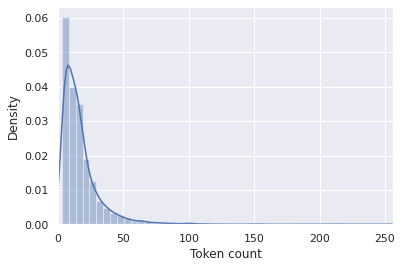

In [40]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')
plt.show()

In [41]:
# from the picture above, the model parameter MAX_LEN is:
MAX_LEN = 120

In [42]:
train_df

,text,labels
723,"integrate new tools like webpack, babel or jest in the pipeline",3.0
2663,"expertise in managing diverse linux systems and handling installation, troubleshooting required configuration for linux.",3.0
108,product manager for pon pol solutions abf systems adc 3 2003 – 2 2007,3.0
550,services.,0.0
2544,"productmanager for software and multimedia applikationen at tronic verlag, eschwege germany",3.0
...,...,...
2484,4 2013 7 2014,0.0
3186,executive summary,0.0
1550,vulnerability and patch management customer reports,3.0
1277,anschrift:,0.0


In [43]:
BATCH_SIZE = 10
# adding missing column:
train_df['text_orig'] = train_df['text']
eval_df['text_orig'] = eval_df['text']

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(eval_df, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/home/bogdan/anaconda3/envs/py37_1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bogdan/anaconda3/envs/py37_1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/bogdan/Desktop/projects/MODIS/Connex/product__network_dev/scripts/model_classification.py:144: SettingWithCopyWarning: 


### Classification with BERT and Hugging Face

In [45]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [47]:
PRE_TRAINED_MODEL_NAME

'dbmdz/bert-base-multilingual-cased-finetuned-conll03-dutch'

In [50]:
n_classes = len(list(df.tag.unique()))
print (n_classes)
model = SentenceClassifier(n_classes, PRE_TRAINED_MODEL_NAME)
model = model.to(device)

6


In [52]:
# training:

In [54]:
EPOCHS = 40
n_classes = 6
model = SentenceClassifier(n_classes, PRE_TRAINED_MODEL_NAME)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [59]:
#
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

#
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

### Create the destination directory for your models:

In [60]:
dir_ = '/home/bogdan/desktop/projects/MODIS/Connex/product__network_dev/scripts/models'

### Start the training:

In [61]:
%%time

gc.collect()
torch.cuda.empty_cache()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(train_df)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(eval_df)
        )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc >= best_accuracy:
        final_file_ = os.path.join(dir_, 'best_model_state.bin')
        torch.save(model.state_dict(), final_file_)
        best_accuracy = val_acc

# save history:
filename_history_ = dir_ + 'history.npy'
np.save(dir_ + 'history.npy', history) 

# save the last model:
torch.save(model.state_dict(), dir_ + 'best_train_model_state.bin')

Epoch 1/40
----------
Train loss 0.5725173251298459 accuracy 0.824719800747198
Val   loss 0.7296153789057451 accuracy 0.7823529411764706

Epoch 2/40
----------
Train loss 0.4175435220244231 accuracy 0.8823163138231631
Val   loss 0.816398266264621 accuracy 0.8

Epoch 3/40
----------
Train loss 0.3487449232286409 accuracy 0.910024906600249
Val   loss 1.1512928307056427 accuracy 0.7764705882352941

Epoch 4/40
----------
Train loss 0.2664080651343933 accuracy 0.9399128268991283
Val   loss 1.0795359892003678 accuracy 0.8

Epoch 5/40
----------
Train loss 0.22967797665211795 accuracy 0.9523661270236613
Val   loss 1.2660686426302965 accuracy 0.7647058823529411

Epoch 6/40
----------
Train loss 0.2050495154364613 accuracy 0.9567247820672478
Val   loss 1.3536748684504454 accuracy 0.7588235294117647

Epoch 7/40
----------
Train loss 0.16384044148661311 accuracy 0.9660647571606475
Val   loss 1.3883312316063572 accuracy 0.7705882352941177

Epoch 8/40
----------
Train loss 0.133192560511861 accurac

In [62]:
print(f'Train loss {train_loss} accuracy {train_acc}')
print(f'Validation loss {val_loss} accuracy {val_acc}')

Train loss 0.004273870141468313 accuracy 0.9978206724782067
Validation loss 2.1012466304442463 accuracy 0.7941176470588235


### Load the best model

In [63]:
# load model:
filename_model_ = dir_ + 'best_model_state.bin'
model = SentenceClassifier(n_classes, PRE_TRAINED_MODEL_NAME)
model.load_state_dict(torch.load(filename_model_))
model = model.to(device)

### evaluation functions for classification:

In [65]:
# evaluation functions
def get_predictions(model, data_loader, device):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    ind = 0
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
            ind += 1

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

# usage:
#review_texts, predictions, prediction_probs, real_values = get_predictions(model, train_data_loader, device)


In [66]:
%%time
y_train_review_texts, y_train_pred, y_train_pred_probs, y_train = get_predictions(
    model,
    train_data_loader, # val_data_loader
    device
)

CPU times: user 18.8 s, sys: 194 ms, total: 19 s
Wall time: 19.2 s


### classification reports

#### Training sample:

In [67]:
class_names = ['personal','languages','education','experience','skills','summary']
print(classification_report(y_train, y_train_pred, target_names=class_names))

              precision    recall  f1-score   support

    personal       1.00      1.00      1.00       729
   languages       1.00      1.00      1.00        55
   education       1.00      1.00      1.00       273
  experience       1.00      1.00      1.00      1635
      skills       1.00      0.99      1.00       376
     summary       1.00      1.00      1.00       144

    accuracy                           1.00      3212
   macro avg       1.00      1.00      1.00      3212
weighted avg       1.00      1.00      1.00      3212



#### Validation sample:

In [68]:
%%time
y_val_review_texts, y_val_pred, y_val_pred_probs, y_val = get_predictions(
    model,
    val_data_loader,
    device
)

CPU times: user 987 ms, sys: 125 ms, total: 1.11 s
Wall time: 1.17 s


In [69]:
class_names = ['personal','languages','education','experience','skills','summary']
print(classification_report(y_val, y_val_pred, target_names=class_names))

              precision    recall  f1-score   support

    personal       0.76      0.74      0.75        39
   languages       1.00      0.67      0.80         3
   education       0.71      0.71      0.71        14
  experience       0.85      0.91      0.88        86
      skills       0.68      0.65      0.67        20
     summary       0.80      0.50      0.62         8

    accuracy                           0.80       170
   macro avg       0.80      0.70      0.74       170
weighted avg       0.80      0.80      0.80       170



#### confusion matrix for the validation sample:

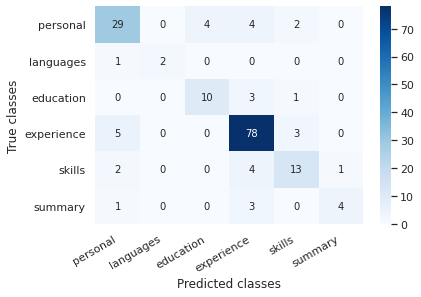

In [70]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True classes')
  plt.xlabel('Predicted classes');

cm = confusion_matrix(y_val, y_val_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [71]:
y_val_review_texts[:10],y_val_pred[:10],y_val[:10]

(['o preparation of the computational infrastructure for the test of a prototype of a pixel and vertex detector on the test beam',
  'leistungsvergleich mit marktbegleitern',
  'linux, windows and apple.',
  '3000 servern virtuelle physikalische server, cloud',
  'support network infrastructure including lan, wan, network hardware, dns, dhcp, tcp ip, firewall and routing protocols, as well as supporting the network printing solutions.',
  'institution telekolleg ii',
  'marketing',
  'sowie interner support und direkter kundenkontakt',
  'nationality german',
  'led design sprint on the selected payment methods with country adoption team, developers and'],
 tensor([3, 3, 4, 3, 3, 2, 3, 3, 0, 3]),
 tensor([3, 3, 4, 3, 3, 0, 3, 4, 0, 3]))

### Check misclassifications:

In many cases the misclassification performed by the model does not turn out to be wrong at all.
Often the human made classification turns out to be incorrect. 
By checking the misclassification you can correct the tags in the training file and perform a new training with smaller error.

In [72]:
df_val = pd.DataFrame()
df_val['text'] = y_val_review_texts
df_val['pred'] = y_val_pred
df_val['true'] = y_val

In [73]:
df_val.shape

(170, 3)

#### false summary (5):

In [74]:
# false summary (5):
tag = 5
df_val[(df_val.pred != tag) & (df_val.true == tag)][['text','true','pred']]

,text,true,pred
92,this,5,0
121,prices created demand for parts of the drawing,5,3
132,"partner and senior leadership team, to ensure actions are followed through to completion",5,3
133,"role: use scrum for software development life cycle model, to use uml to design the system",5,3


#### false skills (4):

In [75]:
# false skills (4):
tag = 4
df_val[(df_val.pred != tag) & (df_val.true == tag)][['text','true','pred']]

,text,true,pred
7,sowie interner support und direkter kundenkontakt,4,3
52,node express moongose,4,0
59,verschiedener services on demand sowie zur abwicklung von zahlungen für dienstleistungen und digitalen produkten,4,3
75,good exposure on lvm svm,4,3
98,level vereinbarung.,4,0
99,honesty and integrity,4,5
110,"high performance computing systems: large scale usage of high performance resource systems on the grid computing network and local computing farms, large data management solutions in heterogeneous distributed environment",4,3


#### false experience (3):

In [76]:
# false experience (3):
tag = 3
df_val[(df_val.pred != tag) & (df_val.true == tag)][['text','true','pred']]

,text,true,pred
11,desk tools such as symbox and jira,3,4
34,environment.,3,0
40,procedures.,3,0
69,strategien,3,4
73,questions,3,0
78,2014 .,3,0
90,sowie weiteren interessengruppen.,3,0
143,produktmanagement,3,4


#### false education (2):

In [77]:
# false education (2):
tag = 2
df_val[(df_val.pred != tag) & (df_val.true == tag)][['text','true','pred']]

,text,true,pred
47,advanced web application,2,4
74,"guest researcher in pusan national university pnu , pusan, south korea",2,3
84,aws certified devops engineer – professional aws certified developer – associate certified rancher operator – level one,2,3
104,"instructor in italy during the month of 8 2016, 2017 and 2018",2,3


#### false languages (1):

In [78]:
# false languages (1):
tag = 1
df_val[(df_val.pred != tag) & (df_val.true == tag)][['text','true','pred']]

,text,true,pred
65,czech,1,0


#### false personal (0):

In [79]:
# false personal (0):
tag = 0
df_val[(df_val.pred != tag) & (df_val.true == tag)][['text','true','pred']]

,text,true,pred
5,institution telekolleg ii,0,2
20,governance,0,4
101,gridwise technologies consultant in grid and distributed systems,0,3
107,deliverables,0,3
115,ibm client innovation center germany,0,2
127,"gerd beuster, head of study program it security",0,3
148,bearbeiten und kenntnisse erweitern mit teradata system administrator tätigkeiten projekt koordination im dwh betrieb,0,3
149,dilara ekrem informatiker ba,0,2
151,ceh v10 from eccouncil,0,4
166,selected professional certifications,0,2
